In [19]:
import os
import json
import cv2
import random
from statistics import mean, median
import seaborn as sns
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from collections import Counter
from pycocotools.coco import COCO

path = '/opt/ml/detection/dataset'
train_json_path = './stratified_kfold/basic_v2/cv_train_1.json'
val_json_path = './stratified_kfold/basic_v2/cv_val_1.json'

cat = ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
color = {
    0: (230, 75, 75), # red
    1: (245, 130, 48), # orange
    2: (255, 255, 25), # yellow 
    3: (210, 245, 60), # lime
    4: (60, 180, 75), # green
    5: (70, 240, 240), #sky blue 
    6: (0, 130, 200), # blue
    7: (145, 30, 180), # purple
    8: (240, 50, 230), # pink
    9: (128, 0, 0) # Brown
}


In [20]:
with open(train_json_path, 'r') as j:
    train_json = json.load(j)

with open(val_json_path, 'r') as j:
    valid_json = json.load(j)
    

In [21]:
train_coco = COCO(train_json_path)
train_image_ids = train_coco.getImgIds()
train_image_infos = train_coco.loadImgs(train_image_ids)

valid_coco = COCO(val_json_path)
valid_image_ids = valid_coco.getImgIds()
valid_image_infos = valid_coco.loadImgs(valid_image_ids)

tr = set(train_image_ids)
vl = set(valid_image_ids)

assert len(np.intersect1d(tr,vl))==0

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [25]:
valid_counter = 0
for img_id in valid_image_ids:
    anns = valid_coco.getAnnIds(imgIds=img_id)
    valid_counter += len(anns)
print(valid_counter)

4511


In [24]:
train_counter = 0
for img_id in train_image_ids:
    anns = train_coco.getAnnIds(imgIds=img_id)
    train_counter += len(anns)
print(train_counter)

18633


In [188]:
def vis_bbox(index, image_ids, image_infos, coco, vis=False):
    img_id = image_ids[index]
    img_info = image_infos[index]
    
    f_name = img_info['file_name']
    anns = coco.getAnnIds(imgIds=img_id)


    image = cv2.imread(path + '/' + img_info['file_name'], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for ann in anns:
        ann_info = coco.loadAnns(ann)[0]
        label = cat[ann_info['category_id']]
        x, y, w, h = map(int, ann_info['bbox'])
        col = color[ann_info['category_id']]
        cv2.rectangle(image, (x,y), (x+w, y+h), col, 5)
        cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, col, 2)
        
    if vis:
        fig , axes = plt.subplots(1,1)
        fig.set_size_inches(9,9)
        plt.imshow(image)
        plt.show()
        
    else:
        return image, len(anns)

In [189]:
def vis_multi_bbox(image_ids, image_infos, coco):
    
    fig , axes = plt.subplots(3,3)
    fig.set_size_inches(15,15)

    for i, num in enumerate(random.sample(range(0, len(image_ids)),9)):
        img, len_anns = vis_bbox(num, image_ids, image_infos, coco)
        axes[i//3, i%3].imshow(img)
        axes[i//3, i%3].set_title(f"{len_anns} annots")
        axes[i//3, i%3].axis('off')
        

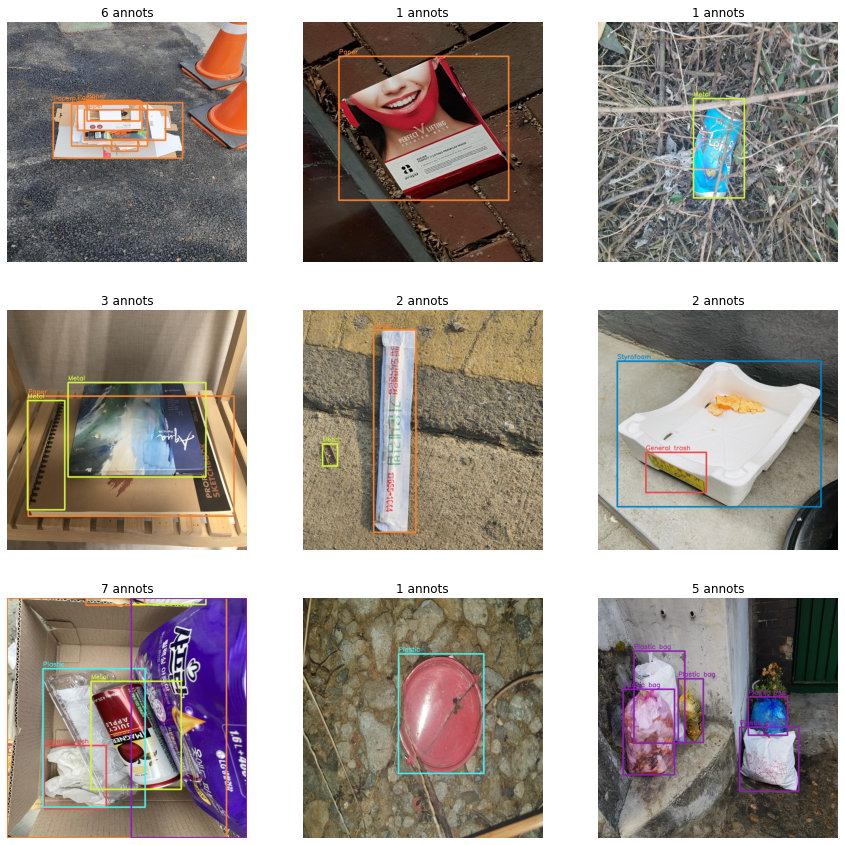

In [190]:
vis_multi_bbox(valid_image_ids, valid_image_infos, valid_coco)

## 통계

In [195]:
# train_json = valid_json

In [196]:
box_size_per_class = {i:[] for i in range(10)}
box_size_total = []
img_id_total = []
cat_total = []
img_size = 1024**2

for i in train_json['annotations']:
    # x,y,w,h = map(int, i['bbox'])
    
    box_size = i['area'] # box 크기
    box_ratio = round(box_size/img_size, 10)
        
    # class별 box 크기 추가
    box_size_per_class[i['category_id']].append(box_ratio)
    
    # box 크기 
    box_size_total.append(box_ratio)
    img_id_total.append(i['image_id'])
    
    # label
    cat_total.append(i['category_id'])

print('Done')

Done


In [197]:
print("box 크기 평균: {:.3f}\n".format(mean(box_size_total)) +
      "box 크기 min: {:.3f}\n".format(min(box_size_total)) +
      "box 크기 max: {:.3f}\n".format(max(box_size_total)) +
      "box 크기 median: {:.3f}\n".format(median(box_size_total)))

index_min = np.argmin(box_size_total)
index_max = np.argmax(box_size_total)

box_df = pd.DataFrame({'bbox_id': np.arange(0, len(box_size_total)), 'box_ratio': box_size_total, 'label': cat_total, 'image_id': img_id_total})

 # 각 칼럼별 범위 지정
bins = np.arange(0, 1.01, 0.01)
# 구간 칼럼 만들기
box_df['interval'] = pd.cut(box_df['box_ratio'], bins=bins ,right = False)


box 크기 평균: 0.089
box 크기 min: 0.000
box 크기 max: 1.000
box 크기 median: 0.037



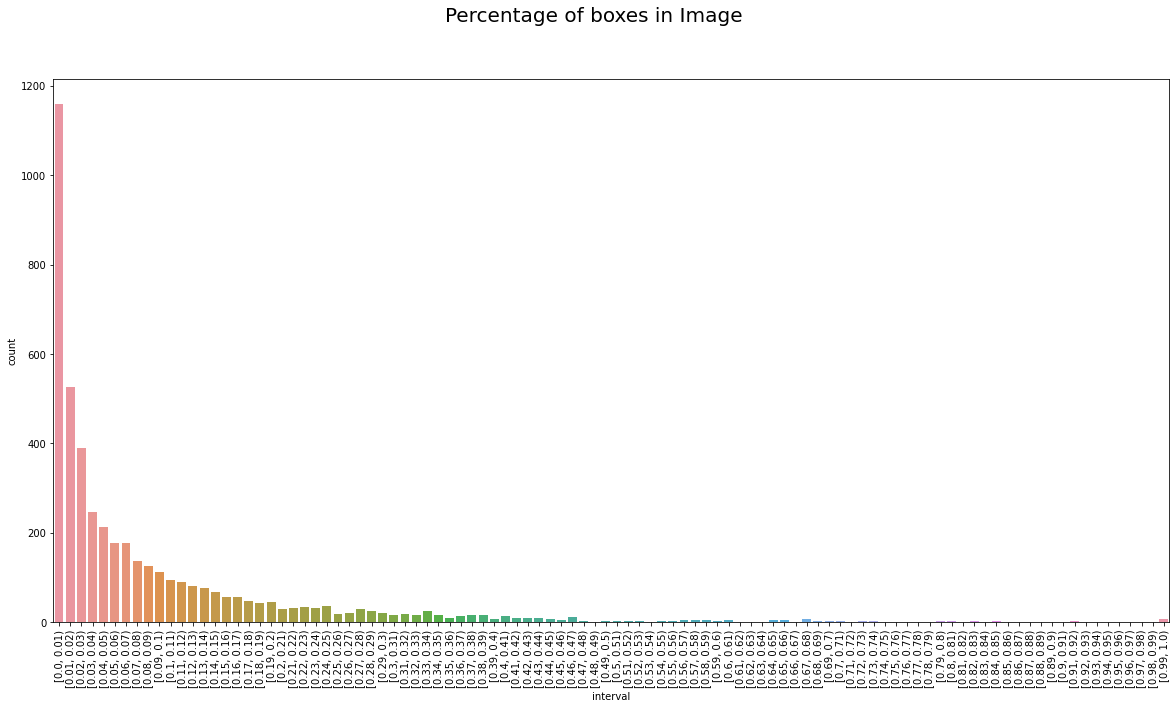

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle("Percentage of boxes in Image", fontsize=20)
ax = sns.countplot(x="interval", data=box_df)
ax.tick_params(axis='x', rotation=90)

In [199]:
print(box_df[box_df['box_ratio']<0.005].shape[0]) # 이미지의 0.01%미만을 차지하는 bounding box가 3개 존재 => 확실히 outlier


750
